In [ ]:
%cd /content/drive/MyDrive/Colab/instate_v2/

/content/drive/MyDrive/Colab/instate_v2


In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split

from fastprogress import master_bar, progress_bar

In [ ]:
# Load the data
df = pd.read_csv('data/final/all_states_with_languages_agg.csv')

In [ ]:
df.head()

,last_name,sindhi,nepali,kannada,marathi,mizo,adi,garo,tagin,assamese,...,telugu,malayalam,tamil,meitei,khasi,gondi,bodo,nishi,chakma,pahari and kumauni
0,aadhumull,0.000,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,bachhar,0.500,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bachhodiya,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bachhole,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,balait,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# drop Nan values
df.dropna(inplace=True)

In [ ]:
agg_dict = {col: 'sum' for col in df.columns if col != 'last_name'}
df = df.groupby('last_name').agg(agg_dict).reset_index()

In [ ]:
df.head()

,last_name,sindhi,nepali,kannada,marathi,mizo,adi,garo,tagin,assamese,...,telugu,malayalam,tamil,meitei,khasi,gondi,bodo,nishi,chakma,pahari and kumauni
0,aadhumull,0.000,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,bachhar,0.500,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bachhodiya,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bachhole,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,balait,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(783089, 38)

## Loading dataset

In [ ]:
class LangDataset(Dataset):
    def __init__(self, dataframe, char2idx):
        self.data = dataframe
        self.last_names = self.data['last_name'].values
        self.labels = self.data.drop(['last_name'], axis=1).values.astype(float)
        self.char2idx = char2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        last_name = self.last_names[idx]
        last_name_indices = [self.char2idx[char] for char in last_name]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        return {'last_name': torch.tensor(last_name_indices, dtype=torch.long), 'labels': labels}

In [ ]:
# Splitting data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
# Generate Character to Index Mapping
chars = set()
for name in df['last_name']:
    chars.update(name)
char2idx = {char: idx + 1 for idx, char in enumerate(chars)}
char2idx['<PAD>'] = 0
idx2char = {idx: char for char, idx in char2idx.items()}

In [ ]:
# Creating datasets and dataloaders
train_dataset = LangDataset(train_df, char2idx)
val_dataset = LangDataset(val_df, char2idx)
test_dataset = LangDataset(test_df, char2idx)

In [ ]:
# display first sample of train_dataset
first_element = train_dataset[0]

# Convert character indices back to the actual characters
last_name_characters = ''.join([idx2char[char.item()] for char in first_element['last_name']])

# Print first element details
print("First element in the train dataset:")
print("Last Name (Character Indices):", first_element['last_name'])
print("Last Name (Characters):", last_name_characters)
print("Labels:", first_element['labels'])

First element in the train dataset:
Last Name (Character Indices): tensor([225, 279,  84, 110, 131,  84, 110, 153, 279, 129])
Last Name (Characters): bhanvanshi
Labels: tensor([0.1250, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [ ]:
def collate_fn(samples):
    last_names = [sample['last_name'] for sample in samples]
    labels = torch.stack([sample['labels'] for sample in samples])
    lengths = torch.tensor([len(name) for name in last_names])
    last_names_padded = pad_sequence(last_names, batch_first=True, padding_value=0)
    return {'last_names': last_names_padded, 'labels': labels, 'lengths': lengths}

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Get the first batch
first_batch = next(iter(train_loader))

# Print the content of the first batch
print("First batch in the train DataLoader:")
print("Last Names (Character Indices):", first_batch['last_names'])
print("Labels:", first_batch['labels'])
print("Lengths:", first_batch['lengths'])

# Convert the character indices back to characters for the first few names in the batch
for i in range(min(3, len(first_batch['last_names']))):  # printing only the first three for brevity
    last_name_indices = first_batch['last_names'][i]
    last_name_characters = ''.join([idx2char[char.item()] for char in last_name_indices if char != 0])
    print(f"Last Name {i+1} (Characters):", last_name_characters)

First batch in the train DataLoader:
Last Names (Character Indices): tensor([[292,  84,  84, 110, 208, 285, 122,   0,   0,   0,   0,   0,   0,   0,
           0],
        [ 83, 237, 198, 198, 279, 129,  44, 129, 292,  84, 103, 129,   0,   0,
           0],
        [ 83, 285,  44,  44, 129, 292, 292,  84, 122,  84,   0,   0,   0,   0,
           0],
        [153,  84, 242, 208, 118,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [103,  76, 254, 237, 150,  84,  44, 237,   0,   0,   0,   0,   0,   0,
           0],
        [153, 279,  84, 122,  84, 242,  84, 254,   0,   0,   0,   0,   0,   0,
           0],
        [153, 118, 258,  84, 208,  84,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [292,  84, 110,  84, 254,  84, 208,  84,   0,   0,   0,   0,   0,   0,
           0],
        [103, 129, 254, 122, 129,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [254, 237, 122, 208, 129, 155, 242,  84,   0,   0,   0,   0,   0,   0,
      

## Model

In [ ]:
class LangModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LangModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        output = self.fc(h_n)
        return output

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# Initialize model, loss function, optimizer
vocab_size = len(char2idx)
embedding_dim = 50
hidden_dim = 128
output_dim = 37
lr = 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LangModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

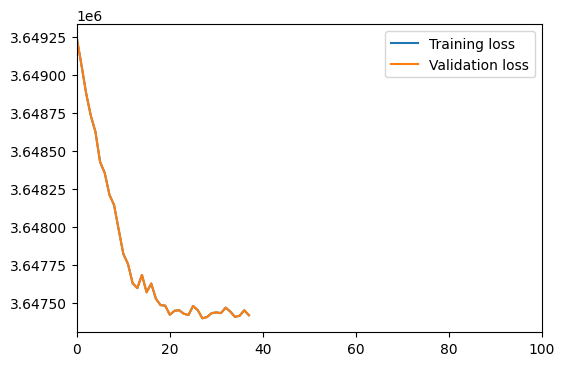

Validation loss decreased (inf --> 5998608.000000).  Saving model ...
Validation loss decreased (5998608.000000 --> 5998256.000000).  Saving model ...
Validation loss decreased (5998256.000000 --> 5997948.000000).  Saving model ...
Validation loss decreased (5997948.000000 --> 5997909.500000).  Saving model ...
Validation loss decreased (5997909.500000 --> 5997896.000000).  Saving model ...
Validation loss decreased (5997896.000000 --> 5997538.500000).  Saving model ...
Validation loss decreased (5997538.500000 --> 5997399.500000).  Saving model ...
Validation loss decreased (5997399.500000 --> 5997134.500000).  Saving model ...
Early stopping at epoch 37


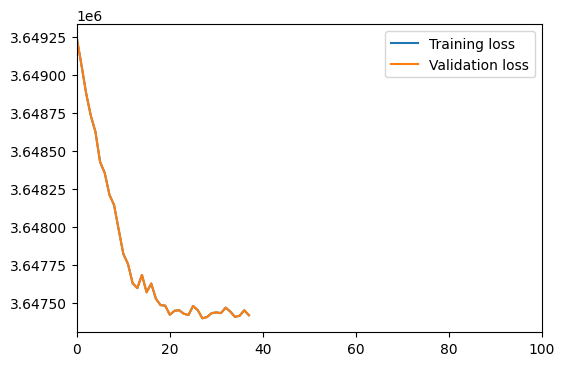

In [ ]:
epochs=100
early_stopper = EarlyStopper(patience=10)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)

mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

# Training loop
for epoch in mb:
  x.append(epoch)
  total_loss = torch.Tensor([0.0]).to(device)

  # train
  model.train()
  for batch in progress_bar(train_loader, parent=mb):
    optimizer.zero_grad()
    last_names = batch['last_names'].to(device)
    labels = batch['labels'].to(device)
    lengths = batch['lengths']
    outputs = model(last_names, lengths)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  # decay lr
  scheduler.step()
  mean = total_loss / len(train_loader)
  training_losses.append(mean.cpu())

  # validation
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_loader, parent=mb):
      last_names = batch['last_names'].to(device)
      labels = batch['labels'].to(device)
      lengths = batch['lengths']
      outputs = model(last_names, lengths)
      loss = criterion(outputs, labels)
      validation_loss += loss.item()

  val_mean = validation_loss / len(val_loader)
  validation_losses.append(mean.cpu())
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")

  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/instate_v2/state_lang.pt')
      valid_mean_min = val_mean.item()

  # early stopping
  if early_stopper.early_stop(validation_losses[-1]):
    print(f"Early stopping at epoch {epoch}")
    break

In [ ]:
# load the model

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/instate_v2/state_lang.pt'))

In [ ]:
langs = df.columns.to_list()
# remove first element in columns
langs.pop(0)

'last_name'

In [ ]:
len(langs)

37

In [50]:
# verify on test dataset
model.eval()
total_matches = 0

with torch.no_grad():
  for batch in test_loader:
    last_names = batch['last_names'].to(device)
    labels = batch['labels'].to(device)
    lengths = batch['lengths']
    outputs = model(last_names, lengths)
    # find the max index on each row
    _, predicted = torch.max(outputs, 1)
    _, true = torch.max(labels, 1)
    # count matches between predicted and true
    matches = (predicted == true).sum().item()
    total_matches += matches

# find ratio between matches and actual
ratio = total_matches / len(test_df)
print(f"Percent of first lang matches: {ratio}")

Percent of first lang matches: 0.4030826597198279


In [ ]:
# do inference based on last_name
def infer(lastname):
  with torch.no_grad():
    last_name_indices = [char2idx[char] for char in lastname]
    last_name_tensor = torch.tensor(last_name_indices, dtype=torch.long).unsqueeze(0).to(device)
    lengths = torch.tensor([len(lastname)], dtype=torch.long)
    outputs = model(last_name_tensor, lengths)
    # get top 3 values index of each output
    _, predicted = torch.topk(outputs, 3, dim=1)
    # index them with langs and send actual langs
    pred_langs = []
    for i in range(3):
      pred_langs.append(langs[predicted[0][i].item()])
    pred_scores = []
    for i in range(3):
      pred_scores.append(outputs[0][predicted[0][i].item()].item())
    return pred_langs, pred_scores

In [ ]:
infer("sood")

In [ ]:
infer("chintalapati")